In [1]:
from fit.datamodules.tomo_rec import MNIST_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram
from fit.utils import denormalize, convert2DFT
from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

import wget
from os.path import exists

from tqdm.notebook import tqdm

from fit.utils import PSNR, denormalize

import odl

In [2]:
seed_everything(22122020)

Global seed set to 22122020


22122020

In [3]:
dm = MNIST_TRecFITDM(root_dir='./datamodules/data/', batch_size=32, num_angles=7)
# FIT: TRec + FBP vs FIT: TRec
with_fbp = False

dm.prepare_data()
dm.setup()

In [4]:
def TV_reconstruction(sino, ray_trafo, reco_space, reg_param = 0.3, niter_bregman = 10):
    data = sino

    # Components for variational problem: l2-squared data matching and isotropic
    # TV-regularization
    l2_norm = 0.5 * odl.solvers.L2NormSquared(ray_trafo.range).translated(data)
    gradient = odl.Gradient(reco_space)
    l12_norm = reg_param * odl.solvers.GroupL1Norm(gradient.range)

    # Assemble functionals and operators for the optimization algorithm
    f = odl.solvers.ZeroFunctional(reco_space)  # No f functional used, set to zero
    g = [l2_norm, l12_norm]
    L = [ray_trafo, gradient]

    # Estimated operator norms, which are used to ensure that we fulfill the
    # convergence criteria of the optimization algorithm
    ray_trafo_norm = odl.power_method_opnorm(ray_trafo, maxiter=20)
    gradient_norm = odl.power_method_opnorm(gradient, maxiter=20)

    # Parameters for the optimization method; tuned in order to reduce the number
    # of inner iterations needed to solve the first step in the Bregman iterations
    niter_inner = 200
    tau = 0.01  # Step size for the primal variable
    sigma_ray_trafo = 45.0 / ray_trafo_norm ** 2  # Step size for dual variable
    sigma_gradient = 45.0 / gradient_norm ** 2  # Step size for dual variable
    sigma = [sigma_ray_trafo, sigma_gradient]
    

    # Create initial guess and initial subgradient
    x = reco_space.zero()
    p = reco_space.zero()

    recos = []
    # This defines the outer Bregman iterations
    for breg_iter in tqdm(range(niter_bregman), leave=False):
#         print('Outer Bregman Iteration: {}'.format(breg_iter))

        # Create the affine part of the Bregman functional
        constant = l12_norm(gradient(x))
        linear_part = reg_param * odl.solvers.QuadraticForm(vector=-p,
                                                            constant=constant)

#         callback_inner = odl.solvers.CallbackPrintIteration(step=50)

        # Inner iterations; x is updated in-place with the consecutive iterates
        odl.solvers.forward_backward_pd(
            x=x, f=f, g=g, L=L, h=linear_part, tau=tau, sigma=sigma,
            niter=niter_inner)

        # Update the subgradient
        p -= (1 / reg_param) * ray_trafo.adjoint(l2_norm.gradient(ray_trafo(x)))

        # Display the result after this iteration
    #     x.T.show(title='Outer Breg|
        recos.append(x.asarray().copy())

    return recos

In [5]:
def get_optimal_TV_rec(sino, gt, ray_trafo, rec_space, reg_params, niter_bregman):
    img_shape = gt.shape[0]
    x, y = torch.meshgrid(torch.arange(-img_shape // 2 + 1,
                                        img_shape // 2 + 1),
                          torch.arange(-img_shape // 2 + 1,
                                        img_shape // 2 + 1))
    circle = torch.sqrt(x ** 2. + y ** 2.) <= img_shape // 2

    def get_gt(gt, circle):
        gt = denormalize(gt, dm.mean, dm.std)
        return circle * gt

    def get_rec(rec, circle):
        rec = denormalize(rec, dm.mean, dm.std)
        return circle * rec
    
    gt = get_gt(gt, circle)
    best_PSNR = 0.
    best_params = {}
    for reg in tqdm(reg_params):
        recs = TV_reconstruction(sino, ray_trafo, reco_space, reg_param=reg, niter_bregman=niter_bregman)

        for i, rec in enumerate(recs):
            rec = get_rec(torch.from_numpy(rec), circle)
            psnr = PSNR(gt, rec, gt.max() - gt.min()).item()
            if psnr > best_PSNR:
                best_PSNR = psnr
                best_params = {'reg_param': reg, 'niter_bregman': i+1, 'rec': rec}
                
                
    
    print('Best Configuration')
    print('PSNR: ', np.round(best_PSNR, 2))
    print(best_params['reg_param'])
    print(best_params['niter_bregman'])
    return best_params['rec'], best_params, best_PSNR, gt

In [6]:
train_dl = dm.train_dataloader()

ray_trafo = train_dl.dataset.ds.dataset.ray_trafo
reco_space = train_dl.dataset.ds.dataset.space[1]

c = 0
results = []
for sino , gt in train_dl.dataset.ds.dataset.get_test_generator():
    if c >= 3:
        break
    c+=1
    best_rec, best_params, best_PSNR, gt_ = get_optimal_TV_rec(sino, gt, ray_trafo, reco_space, 
                                           reg_params=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                           niter_bregman=10)
    results.append({'rec': best_rec, 'params': best_params, 'psnr': best_PSNR, 'gt': gt_})

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Best Configuration
PSNR:  24.42
0.6
6


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Best Configuration
PSNR:  23.93
0.5
7


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Best Configuration
PSNR:  21.27
0.2
10


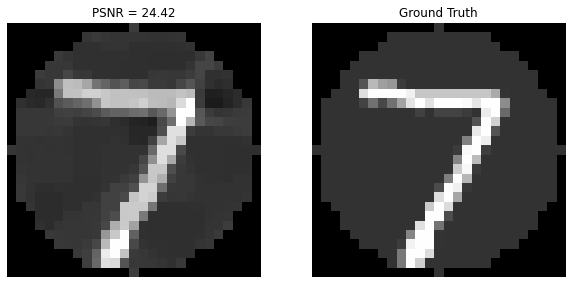

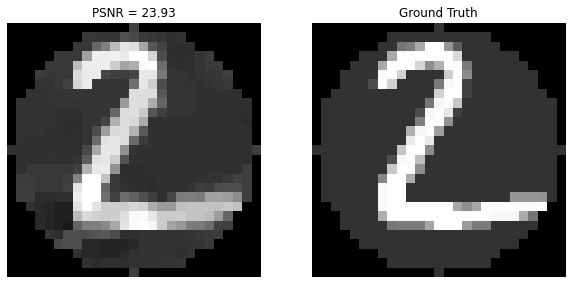

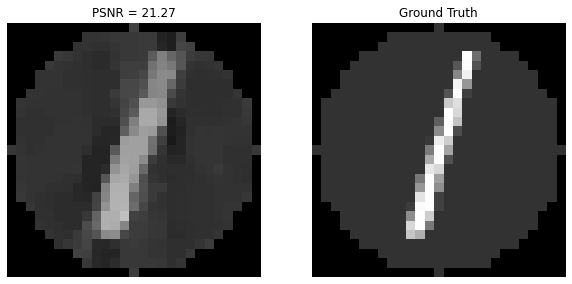

In [7]:
for res in results:
    gt = res['gt']
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(res['rec'], cmap='gray', vmin=gt.min(), vmax=gt.max())
    plt.axis('off');
    plt.title('PSNR = {:2.2f}'.format(res['psnr']))
    plt.subplot(1,2,2)
    plt.imshow(gt, cmap='gray')
    plt.axis('off');
    plt.title('Ground Truth')

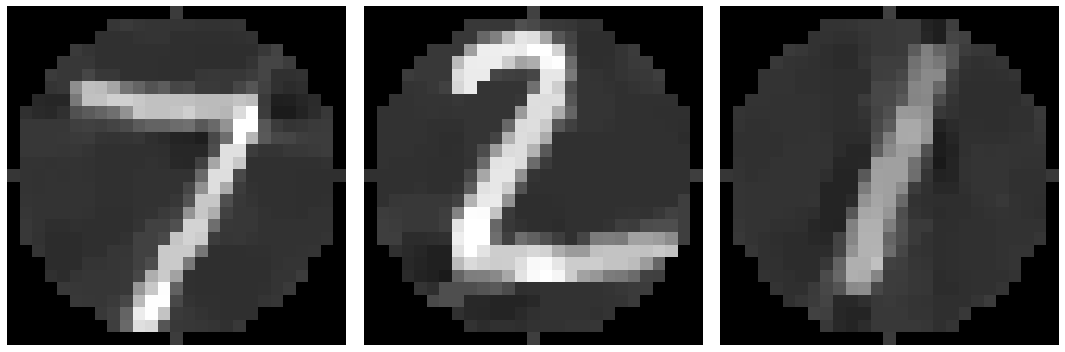

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
gt = results[0]['gt']
plt.imshow(results[0]['rec'], cmap='gray', vmin=gt.min(), vmax=gt.max())
plt.axis('off');
plt.subplot(1,3,2)
gt = results[1]['gt']
plt.imshow(results[1]['rec'], cmap='gray', vmin=gt.min(), vmax=gt.max())
plt.axis('off');
plt.subplot(1,3,3)
gt = results[2]['gt']
plt.imshow(results[2]['rec'], cmap='gray', vmin=gt.min(), vmax=gt.max())
plt.axis('off');
plt.tight_layout()
plt.savefig('MINST_TV_Rec.pdf', bbox_inches='tight', pad_inches=0.0)